In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B", legacy=False)

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def length_function(text: str) -> int:
    return len(tokenizer(text)['input_ids'])

In [11]:
def splitter_length(text: str, name: str, use_tqdm: bool = True):
    sizes_length = [16, 32, 64, 128, 256, 512, 1024]
    
    for size in sizes_length:
        overlap = int(size / 5)
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=size, 
            chunk_overlap=overlap,
            length_function=length_function,
        )

        splits = splitter.split_text(text)
        splits = [split for split in splits if len(split) > 1]  # Filtra splits com tamanho > 1

        if use_tqdm:
            iterator = tqdm(splits, desc=f"Processando chunks de tamanho {size}")
        else:
            iterator = splits

        inserts = []
        last_found = 0  # Rastro da posição atual no texto

        for split in iterator:
            # Ajusta a posição de busca para incluir a sobreposição
            search_start = max(last_found - overlap, 0)
            indice = text.find(split, search_start)
            
            if indice == -1:
                # Se não encontrado a partir de search_start, tenta buscar globalmente
                indice = text.find(split)
                if indice == -1:
                    print(f"Split não encontrado: {split[:30]}...")
                    continue

            inserts.append((split, indice, name))
            # Atualiza a posição atual levando em conta a sobreposição
            last_found = indice + len(split) - overlap

        # Insere os dados em lote no banco de dados
        if inserts:
            try:
                conn.executemany("""
                    INSERT INTO dataset (content, indice, name)
                    VALUES (?, ?, ?)
                """, inserts)
                conn.commit()
            except Exception as e:
                print(f"Erro ao inserir dados no DuckDB: {e}")

In [3]:
import numpy as np

def signed_log_transform(y):
    return np.sign(y) * np.log1p(np.abs(y))

def inverse_signed_log_transform(y_transformed):
    return np.sign(y_transformed) * (np.expm1(np.abs(y_transformed)))

def dissimilaridade(S):
	epsilon = 0
	if S == 0:
		max_x = np.log(np.finfo(np.float32).max)
		epsilon = (1/(max_x-1))
        
	return (1 - (S+epsilon)) / (S+epsilon)

In [4]:
import html2text
from cleantext import clean

# Configurar o conversor
converter = html2text.HTML2Text()
converter.ignore_links = True
converter.ignore_images = True
converter.ignore_tables = True

def cleartext(decoded_html):
	texto_limpo = converter.handle(decoded_html)
	texto_limpo = clean(
		texto_limpo,
		fix_unicode=True,
		to_ascii=False,
		lower=False,
		no_line_breaks=True,
		no_urls=True,
		no_emails=True,
		no_phone_numbers=True,
		no_numbers=False,
		no_digits=False,
		no_currency_symbols=True,
		no_punct=False,  # Defina como True se quiser remover pontuação
		replace_with_punct="",
		replace_with_url="",
		replace_with_email="",
		replace_with_phone_number="",
		replace_with_number="",
		replace_with_digit="",
		replace_with_currency_symbol=""
	)

	return texto_limpo

In [1]:
import duckdb
from tqdm import tqdm

# Conectar ou criar o banco de dados DuckDB
conn = duckdb.connect('books.duckdb')

In [6]:
# Criar a tabela de e-mails se não existir
conn.execute("""
CREATE SEQUENCE IF NOT EXISTS serial;
             
CREATE TABLE IF NOT EXISTS dataset (
    id INTEGER DEFAULT nextval('serial'),
    name VARCHAR(255),
    content TEXT,
    indice INTEGER
)
""")

In [7]:
import os

for f in os.listdir('./books'):
	if os.path.isfile(os.path.join('./books', f)):
		with open(os.path.join('./books', f), 'r', encoding='utf-8') as file:
			print(os.path.join('./books', f))
			splitter_length(cleartext(file.read()),f)

./books/Unknown - ana rosa.txt


Processando chunks de tamanho 1024: 100%|██████████| 251/251 [00:00<00:00, 798.05it/s]


./books/Ao Seu Lado - Kasie West.txt


Processando chunks de tamanho 1024: 100%|██████████| 292/292 [00:03<00:00, 78.88it/s] 


./books/Amor em Roma - Sarah Adams.txt


Processando chunks de tamanho 1024: 100%|██████████| 418/418 [00:00<00:00, 801.54it/s]


./books/The Rule Book - Sarah Adams.txt


Processando chunks de tamanho 1024: 100%|██████████| 417/417 [00:04<00:00, 91.41it/s] 


./books/Marriage for One - Ella Maise.txt


Processando chunks de tamanho 1024: 100%|██████████| 600/600 [00:07<00:00, 80.89it/s] 


./books/The Worst Best Man - Mia Sosa.txt


Processando chunks de tamanho 1024: 100%|██████████| 386/386 [00:00<00:00, 725.10it/s]


./books/Para sempre seu - Abby Jimenez.txt


Processando chunks de tamanho 1024: 100%|██████████| 491/491 [00:00<00:00, 794.21it/s]


./books/O efeito Graham - Elle Kennedy.txt


Processando chunks de tamanho 1024: 100%|██████████| 675/675 [00:00<00:00, 765.23it/s]


./books/Um feitico de amor - Kate Robb.txt


Processando chunks de tamanho 1024: 100%|██████████| 430/430 [00:00<00:00, 727.27it/s]


./books/Mais que Amigos - Lauren Layne.txt


Processando chunks de tamanho 1024: 100%|██████████| 279/279 [00:00<00:00, 678.65it/s]


./books/Operacao paixao - Carlie Walker.txt


Processando chunks de tamanho 1024: 100%|██████████| 465/465 [00:00<00:00, 797.01it/s]


./books/Os numeros do amor - Helen Hoang.txt


Processando chunks de tamanho 1024: 100%|██████████| 400/400 [00:01<00:00, 322.60it/s]


./books/Missao Romance - Lyssa Kay Adams.txt


Processando chunks de tamanho 1024: 100%|██████████| 384/384 [00:00<00:00, 748.52it/s]


./books/Dez Dates Surpresa - Ashley Elston.txt


Processando chunks de tamanho 1024: 100%|██████████| 341/341 [00:00<00:00, 750.87it/s]


./books/Declinio de um homem - Osamu Dazai.txt


Processando chunks de tamanho 1024: 100%|██████████| 147/147 [00:00<00:00, 757.35it/s]


./books/O principio do coracao - Helen Hoang.txt


Processando chunks de tamanho 1024: 100%|██████████| 410/410 [00:00<00:00, 830.47it/s]


./books/The Trouble with Love - Lauren Layne.txt


Processando chunks de tamanho 1024: 100%|██████████| 278/278 [00:06<00:00, 44.44it/s]


./books/A cancao de Aquiles - Madeline Miller.txt


Processando chunks de tamanho 1024: 100%|██████████| 473/473 [00:01<00:00, 343.79it/s]


./books/O Crime do Padre Amaro - Eca de Queiros.txt


Processando chunks de tamanho 1024: 100%|██████████| 671/671 [00:00<00:00, 688.39it/s]


./books/Love the One You're With - Lauren Layne.txt


Processando chunks de tamanho 1024: 100%|██████████| 310/310 [00:00<00:00, 786.91it/s]


./books/Sozinha ou acompanhada_ - Mazey Eddings.txt


Processando chunks de tamanho 1024: 100%|██████████| 418/418 [00:01<00:00, 252.58it/s]


./books/Visoes de Descartes - Olavo de Carvalho.txt


Processando chunks de tamanho 1024: 100%|██████████| 285/285 [00:00<00:00, 288.91it/s]


./books/Clube do livro dos homens - Adams, Lyssa Kay.txt


Processando chunks de tamanho 1024: 100%|██████████| 380/380 [00:00<00:00, 647.92it/s]


./books/Uma farsa de amor na Espanha_ Conteudo Ext - Armas, Elena.txt


Processando chunks de tamanho 1024: 100%|██████████| 37/37 [00:00<00:00, 297.22it/s]


./books/Ed & Lorraine Warren - Lugar Sombrio - Carmen Reed.txt


Processando chunks de tamanho 1024: 100%|██████████| 417/417 [00:00<00:00, 785.00it/s]


./books/A longa marcha da vaca para o brejo_ E, lo - de Carvalho, Olavo.txt


Processando chunks de tamanho 1024: 100%|██████████| 330/330 [00:00<00:00, 807.86it/s]


./books/D__wwwroot_cleverpdf-web_4707484_Demonolog - Desconhecido.txt


Processando chunks de tamanho 1024: 100%|██████████| 440/440 [00:00<00:00, 668.89it/s]


./books/The American Roommate Experiment_ A Novel - Elena Armas.txt


Processando chunks de tamanho 1024: 100%|██████████| 489/489 [00:00<00:00, 726.77it/s]


./books/I Think I Love You_ An Exciting New Romanc - Lauren Layne.txt


Processando chunks de tamanho 1024: 100%|██████████| 282/282 [00:00<00:00, 843.75it/s]


./books/Just One Night_ Sex, Love & Stiletto Serie - Lauren Layne.txt


Processando chunks de tamanho 1024: 100%|██████████| 291/291 [00:00<00:00, 816.80it/s]


./books/Estupidamente apaixonados - Lyssa Kay Adams.txt


Processando chunks de tamanho 1024: 100%|██████████| 400/400 [00:00<00:00, 828.73it/s]


./books/Aristoteles em nova perspectiva - Olavo de Carvalho.txt


Processando chunks de tamanho 1024: 100%|██████████| 167/167 [00:00<00:00, 289.94it/s]


./books/O imbecil coletivo _ Atualidades incultura - Olavo de Carvalho.txt


Processando chunks de tamanho 1024: 100%|██████████| 681/681 [00:00<00:00, 692.41it/s]


./books/O jardim das Aflicoes_ de Epicuro a ressur - Olavo de Carvalho.txt


Processando chunks de tamanho 1024: 100%|██████████| 645/645 [00:00<00:00, 762.10it/s]


./books/O minimo que voce precisa saber para nao s - Olavo de Carvalho.txt


Processando chunks de tamanho 1024: 100%|██████████| 1083/1083 [00:02<00:00, 362.56it/s]


./books/Biblia Sagrada Nova Almeida Atualizada - Sociedade Biblica do Brasil.txt


Processando chunks de tamanho 1024: 100%|██████████| 3739/3739 [00:06<00:00, 545.38it/s]


In [14]:
import pandas as pd

splits = {'train': 'squad_v2/train-00000-of-00001.parquet', 'validation': 'squad_v2/validation-00000-of-00001.parquet'}

# Carregar os dados de treino e validação em DataFrames separados
df_train = pd.read_parquet("hf://datasets/rajpurkar/squad_v2/" + splits["train"])
df_validation = pd.read_parquet("hf://datasets/rajpurkar/squad_v2/" + splits["validation"])

# Concatenar os dois DataFrames
df = pd.concat([df_train, df_validation], ignore_index=True)

# Extrair o texto da resposta, verificando se a lista de respostas não está vazia
df['answer_text'] = df['answers'].apply(lambda x: x['text'][0] if len(x['text']) > 0 else '')

# Concatenar a pergunta com a resposta em uma nova coluna
df['text'] = df['context'] + " " + df['question'] + " " + df['answer_text']
df

,id,title,context,question,answers,answer_text,text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'...",in the late 1990s,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star...",singing and dancing,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}",2003,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [...","Houston, Texas",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}",late 1990s,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
...,...,...,...,...,...,...,...
142187,5737aafd1c456719005744ff,Force,"The pound-force has a metric counterpart, less...",What is the seldom used force unit equal to on...,"{'text': ['sthène', 'sthène', 'sthène', 'sthèn...",sthène,"The pound-force has a metric counterpart, less..."
142188,5ad28ad0d7d075001a4299cc,Force,"The pound-force has a metric counterpart, less...",What does not have a metric counterpart?,"{'text': [], 'answer_start': []}",,"The pound-force has a metric counterpart, less..."
142189,5ad28ad0d7d075001a4299cd,Force,"The pound-force has a metric counterpart, less...",What is the force exerted by standard gravity ...,"{'text': [], 'answer_start': []}",,"The pound-force has a metric counterpart, less..."
142190,5ad28ad0d7d075001a4299ce,Force,"The pound-force has a metric counterpart, less...",What force leads to a commonly used unit of mass?,"{'text': [], 'answer_start': []}",,"The pound-force has a metric counterpart, less..."


In [15]:
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="squad_v2"):
	splitter_length(row['text'],row['id'],use_tqdm=False)

squad_v2: 100%|██████████| 142192/142192 [8:35:05<00:00,  4.60it/s]   


In [13]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/sentence-transformers/stsb/" + splits["train"])
#df_validation = pd.read_parquet("hf://datasets/sentence-transformers/stsb/" + splits["validation"])
#df_test = pd.read_parquet("hf://datasets/sentence-transformers/stsb/" + splits["test"])
#df = pd.concat([df_train, df_validation,df_test], ignore_index=True)

df_train['Diferença'] = df_train['score'].apply(lambda x: inverse_signed_log_transform(dissimilaridade(x)))
df_train

,sentence1,sentence2,score,Diferença
0,A plane is taking off.,An air plane is taking off.,1.00,0.000000e+00
1,A man is playing a large flute.,A man is playing a flute.,0.76,3.713415e-01
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76,3.713415e-01
3,Three men are playing chess.,Two men are playing chess.,0.52,1.517023e+00
4,A man is playing the cello.,A man seated is playing the cello.,0.85,1.929993e-01
...,...,...,...,...
5744,Severe Gales As Storm Clodagh Hits Britain,Merkel pledges NATO solidarity with Latvia,0.00,4.605222e+37
5745,Dozens of Egyptians hostages taken by Libyan t...,Egyptian boat crash death toll rises as more b...,0.00,4.605222e+37
5746,President heading to Bahrain,President Xi: China to continue help to fight ...,0.00,4.605222e+37
5747,"China, India vow to further bilateral ties",China Scrambles to Reassure Jittery Stock Traders,0.00,4.605222e+37


In [ ]:
import uuid

for index, row in tqdm(df_train.iterrows(), total=df_train.shape[0], desc="sentence-transformers"):
    run_uid = uuid.uuid4().hex[:6]
    
	# Como esse dataset não tem a posição pode estar no passado ou no futuro
    inserts = [
        (row['sentence1'], -(row['score']/2), run_uid),
        (row['sentence2'], (row['score']/2), run_uid),
        (row['sentence1'], (row['score']/2), run_uid),
        (row['sentence2'], -(row['score']/2), run_uid)
    ]
    try:
        # Usar executemany para inserir múltiplas linhas de uma vez
        conn.executemany("""
            INSERT INTO dataset (content, indice, name)
            VALUES (?, ?, ?)
        """, inserts)
    except Exception as e:
        print(f"Erro ao inserir dados no DuckDB: {e}")

sentence-transformers: 100%|██████████| 5749/5749 [00:50<00:00, 113.35it/s]


In [7]:
from datasets import load_dataset

# Carrega o dataset em modo de streaming
fw = load_dataset("./fineweb", streaming=True)

# Verifique os splits disponíveis (como 'train', 'test', etc.)
print(fw)

IterableDatasetDict({
    train: IterableDataset({
        features: ['text', 'id', 'dump', 'url', 'date', 'file_path', 'language', 'language_score', 'token_count'],
        n_shards: 1
    })
})


In [8]:
sizes_length = [16, 32, 64, 128, 256, 512, 1024]
use_tqdm = False
counter = 0
max_samples = 2303690

for sample in tqdm(fw['train'], desc="fineweb"):
	if counter >= max_samples:
		break
	
	text = cleartext(sample['text'])
	name = sample['url']
	
	for size in sizes_length:
		overlap = int(size / 5)
		splitter = RecursiveCharacterTextSplitter(
			chunk_size=size, 
			chunk_overlap=overlap,
			length_function=length_function,
		)

		splits = splitter.split_text(text)
		splits = [split for split in splits if len(split) > 1]  # Filtra splits com tamanho > 1

		if use_tqdm:
			iterator = tqdm(splits, desc=f"Processando chunks de tamanho {size}")
		else:
			iterator = splits

		inserts = []
		last_found = 0  # Rastro da posição atual no texto

		for split in iterator:
			# Ajusta a posição de busca para incluir a sobreposição
			search_start = max(last_found - overlap, 0)
			indice = text.find(split, search_start)
			
			if indice == -1:
				# Se não encontrado a partir de search_start, tenta buscar globalmente
				indice = text.find(split)
				if indice == -1:
					print(f"Split não encontrado: {split[:30]}...")
					continue

			inserts.append((split, indice, name))
			counter += 1
			# Atualiza a posição atual levando em conta a sobreposição
			last_found = indice + len(split) - overlap

		# Insere os dados em lote no banco de dados
		if inserts:
			try:
				conn.executemany("""
					INSERT INTO dataset (content, indice, name)
					VALUES (?, ?, ?)
				""", inserts)
				conn.commit()
			except Exception as e:
				print(f"Erro ao inserir dados no DuckDB: {e}")

fineweb: 8667it [2:56:53,  1.22s/it]


In [15]:
df = conn.execute("""SELECT * FROM dataset """).df()
df

,id,name,content,indice
0,1,Unknown - ana rosa.txt,Disponibilização : Lizzie,0
1,2,Unknown - ana rosa.txt,"Lizzie Tradução: Andréa,",19
2,3,Unknown - ana rosa.txt,Elisangela e Regina Revisão,44
3,4,Unknown - ana rosa.txt,Inicial: Andréa e Elisangela,72
4,5,Unknown - ana rosa.txt,Revisão Final: Sophy,101
...,...,...,...,...
2315183,2315184,77b9af,President Xi: China to continue help to fight ...,0
2315184,2315185,6d0dba,"China, India vow to further bilateral ties",0
2315185,2315186,6d0dba,China Scrambles to Reassure Jittery Stock Traders,0
2315186,2315187,bca375,Putin spokesman: Doping charges appear unfounded,0


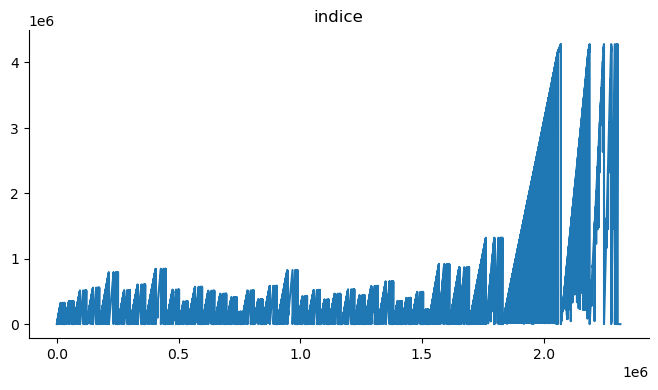

In [16]:
# @title indice

from matplotlib import pyplot as plt
df['indice'].plot(kind='line', figsize=(8, 4), title='indice')
plt.gca().spines[['top', 'right']].set_visible(False)

In [2]:
df_training = conn.execute("""
WITH sampled_a AS (
  SELECT id, indice, content, name
  FROM (
    SELECT
      id,
      indice,
      content,
      name,
      ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
    FROM dataset
  ) sub
  WHERE rn <= 100 -- Número de amostras desejadas por grupo para 'a'
),
sampled_b AS (
  SELECT id, indice, content, name
  FROM (
    SELECT
      id,
      indice,
      content,
      name,
      ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
    FROM dataset
  ) sub
  WHERE rn <= 100 -- Número de amostras desejadas por grupo para 'b'
)
SELECT
  a.name as name,
  a.content AS content1,
  b.content AS content2,
  SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed
FROM sampled_a a
JOIN sampled_b b
  ON a.name = b.name
  AND a.id != b.id
ORDER BY RANDOM()
LIMIT 30000;
""").df()
df_training

,name,content1,content2,target_transformed
0,O efeito Graham - Elle Kennedy.txt,"dá uma risadinha. ""Vou ligar pro meu pai"", avi...","""Eu também. Estava precisando",11.287417
1,I Think I Love You_ An Exciting New Romanc - L...,"a trabalho, mas que ligaria",à parte — Nick disse com um olhar de advertênc...,-11.723737
2,D__wwwroot_cleverpdf-web_4707484_Demonolog - D...,'Qual é a sua,adentra em uma dimensão muito mais profunda — ...,13.126443
3,Marriage for One - Ella Maise.txt,"any and all events, rarely",it just as it had,12.592470
4,Love the One You're With - Lauren Layne.txt,wrote about how couples who run together have ...,website on their respective home,-11.367900
...,...,...,...,...
29995,The American Roommate Experiment_ A Novel - El...,being the handsomest of them,"Graham, are a boss-lady.""",12.743156
29996,The Worst Best Man - Mia Sosa.txt,agreeable in this position. Despite the limpne...,"stiff and high, until it settles in the air, s...",-11.322334
29997,Estupidamente apaixonados - Lyssa Kay Adams.txt,É óbvio que ela,Havia certa solidão em,-9.229260
29998,Missao Romance - Lyssa Kay Adams.txt,"a verdade, a única mulher a quem conseguia se ...","dor, e Liv não entendeu nada. A maçaneta machu...",10.629392


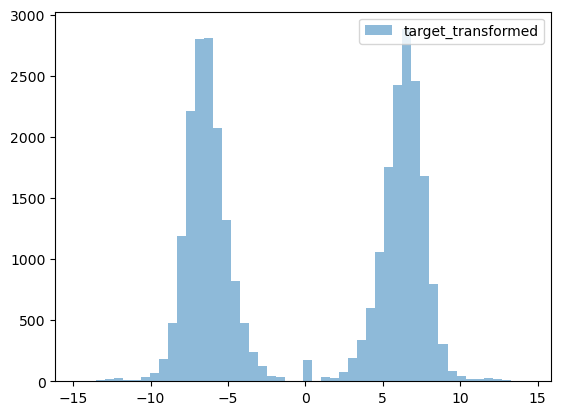

In [2]:
import matplotlib.pyplot as plt

plt.hist(df_training['target_transformed'], bins=50, alpha=0.5, label='target_transformed')
plt.legend()
plt.show()

In [9]:
# Fechar a conexão com o banco de dados
conn.close()

In [ ]:
import duckdb
from tqdm import tqdm

# Caminhos para os bancos de dados
db1_path = 'fineweb.duckdb'  # Substitua pelo caminho do seu primeiro banco de dados
db2_path = 'books.duckdb'  # Substitua pelo caminho do seu segundo banco de dados

# Alias para o segundo banco de dados
alias_db2 = 'db2_alias'

# Conectar ao banco de dados principal
conn = duckdb.connect(database=db1_path, read_only=False)


# Anexar o segundo banco de dados
conn.execute(f"ATTACH DATABASE '{db2_path}' AS {alias_db2}")

# Verificar esquemas (opcional, mas recomendado)
schema_main = conn.execute("DESCRIBE dataset").fetchdf()
schema_db2 = conn.execute(f"DESCRIBE {alias_db2}.dataset").fetchdf()

if not schema_main.equals(schema_db2):
	raise Exception("Os esquemas das tabelas 'dataset' nos dois bancos de dados não são compatíveis.")

# Executar a consulta modificada
df_training = conn.execute(f"""
WITH combined_dataset AS (
	SELECT * FROM dataset
	UNION ALL
	SELECT * FROM {alias_db2}.dataset
),
sampled_a AS (
	SELECT id, indice, content, name
	FROM (
	SELECT
		id,
		indice,
		content,
		name,
		ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
	FROM combined_dataset
	) sub
	WHERE rn <= 100
),
sampled_b AS (
	SELECT id, indice, content, name
	FROM (
	SELECT
		id,
		indice,
		content,
		name,
		ROW_NUMBER() OVER (PARTITION BY name ORDER BY RANDOM()) AS rn
	FROM combined_dataset
	) sub
	WHERE rn <= 100
)
SELECT
	a.name AS name,
	a.content AS content1,
	b.content AS content2,
	SIGN(a.indice - b.indice) * LN(1 + ABS(a.indice - b.indice)) AS target_transformed
FROM sampled_a a
JOIN sampled_b b
	ON a.name = b.name
	AND a.id != b.id
ORDER BY RANDOM()
LIMIT 30000;
""").df()

df_training

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,name,content1,content2,target_transformed
0,http://www.bigw.org/members/,"File Covers basic Unix commands, how to use e-...",Log Statistics You can now monitor the traffic...,-4.454347
1,http://transcentury.blogspot.com/2016/12/its-a...,"Man. In Dog Man Unleashed, our hero has to","new rain gear. In ""Sitting Up Straight,"" a boy",-8.005033
2,http://www.upi.com/blog/2013/07/15/Trayvon-Mar...,"said, several ""splinter groups"" have been more...","downtown, while police in riot gear watched ov...",-6.606650
3,http://www.ecologyandsociety.org/vol18/iss1/art4/,listed in Annex I of,the 92/43/EEC Habitats,8.882392
4,http://www.phonearena.com/news/LG-infographic-...,older. 20% of those,that 75% of Americans would have no problem us...,5.605802
...,...,...,...,...
29995,http://nbpd.org/services/vacationcheck.asp,Not Stopped Stopped Picked,Any pets at the residence,-5.676754
29996,https://fascinaction.hettich.com/en-de/misc-na...,pages may also have contents subject to the co...,and the like) of its Internet pages. The prote...,6.100319
29997,http://forums.devshed.com/mail-server-help-111...,are using. I've done a little research and I know,call RR I'm guessing they'll give you an addre...,-7.107425
29998,http://psychology.wikia.com/wiki/Semantic_Web,such as items for sale,late 1980s and early,-7.788626


In [3]:
conn.execute(f"DETACH DATABASE {alias_db2}")
# Fechar a conexão com o banco de dados
conn.close()